In [2]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import torchvision.transforms as transforms
import time
import os
from sklearn.model_selection import train_test_split

import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt

In [4]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# 1. Load the Data

In [5]:
path = '/workspaces/aps360-winter2023/converted-data'

In [6]:
# Resize images to 288 x 288
transform = transforms.Compose([transforms.Resize((288, 288)),
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                                transforms.ToTensor()])

# Normalize the data later!!

# TRANSFORMING THE DATA
data = torchvision.datasets.ImageFolder(path, transform=transform)

In [7]:
train_data, valtest_data = random_split(data, (15587, 1948*2))
val_data, test_data = random_split(valtest_data, (1948, 1948))

In [7]:
print(val_data[0])

(tensor([[[0.1922, 0.1882, 0.1804,  ..., 0.2706, 0.2667, 0.2667],
         [0.2471, 0.2235, 0.1882,  ..., 0.2667, 0.2667, 0.2667],
         [0.2431, 0.2235, 0.1882,  ..., 0.2667, 0.2667, 0.2667],
         ...,
         [0.1569, 0.1686, 0.1804,  ..., 0.2353, 0.2431, 0.2471],
         [0.1961, 0.1882, 0.1765,  ..., 0.2275, 0.2353, 0.2392],
         [0.2667, 0.2471, 0.2157,  ..., 0.2314, 0.2431, 0.2510]],

        [[0.3922, 0.4000, 0.4157,  ..., 0.0196, 0.0118, 0.0039],
         [0.1647, 0.2471, 0.3882,  ..., 0.0078, 0.0078, 0.0078],
         [0.1882, 0.2627, 0.3882,  ..., 0.0039, 0.0078, 0.0118],
         ...,
         [0.4824, 0.4627, 0.4235,  ..., 0.2980, 0.2824, 0.2745],
         [0.3922, 0.4118, 0.4431,  ..., 0.3216, 0.3020, 0.2902],
         [0.2235, 0.2706, 0.3490,  ..., 0.3176, 0.2863, 0.2667]],

        [[0.5529, 0.5529, 0.5569,  ..., 0.3490, 0.3373, 0.3294],
         [0.4314, 0.4745, 0.5412,  ..., 0.3373, 0.3373, 0.3373],
         [0.4471, 0.4824, 0.5412,  ..., 0.3294, 0.3373, 0

In [10]:
'''
n = len(data)
n_valtest = int(0.2 * n)
valtest_data = torch.utils.data.Subset(data, range(n_valtest))
train_data = torch.utils.data.Subset(data, range(n_valtest, n))
'''

'\nn = len(data)\nn_valtest = int(0.2 * n)\nvaltest_data = torch.utils.data.Subset(data, range(n_valtest))\ntrain_data = torch.utils.data.Subset(data, range(n_valtest, n))\n'

In [11]:
'''
n = len(valtest_data)
n_test = int(0.5 * n)
val_data = torch.utils.data.Subset(data, range(n_test))
test_data = torch.utils.data.Subset(data, range(n_test, n))
'''

'\nn = len(valtest_data)\nn_test = int(0.5 * n)\nval_data = torch.utils.data.Subset(data, range(n_test))\ntest_data = torch.utils.data.Subset(data, range(n_test, n))\n'

In [8]:
# LOADING THE DATA
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=1, shuffle=True)

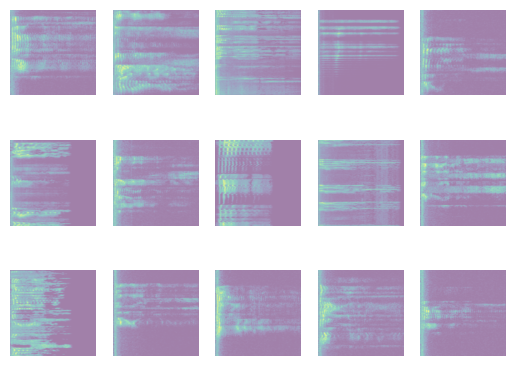

In [11]:
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [9]:
train_examples = len(train_loader)
validation_examples = len(val_loader)
test_examples = len(test_loader)

print("Number of training examples:", train_examples)
print("Number of validation examples:", validation_examples)
print("Number of testing examples:", test_examples)

Number of training examples: 15587
Number of validation examples: 1948
Number of testing examples: 1948


# 2. Define the Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 7) # RGB 3 input channels, 5 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv2 = nn.Conv2d(5, 10, 7) # 5 input channels, 10 output channels, 5 x 5 kernel size
        self.pool = nn.MaxPool2d(3, 1) # 3 x 3 kernel size, 1 stride
        self.conv3 = nn.Conv2d(10, 15, 3) # 10 input channels, 15 output channels, 3 x 3 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv4 = nn.Conv2d(15, 20, 3) # 15 input channels, 20 output channels, 3 x 3 kernel size

        # 26 x 26 (20ch) => flat => 26 x 26 x 20
        # self.fc1 = nn.Linear(20 * 26 * 26, 50) # 50 hidden neurons
        self.fc1 = nn.Linear(10 * 29 * 29, 50)
        self.fc2 = nn.Linear(50, 6) # 6 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 20 * 26 * 26)
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # flatten to [batch_size]
        return x

In [8]:
def get_accuracy(model, train_loader, val_loader, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        # select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [9]:
def train(model, train_data, val_data, batch_size=64, learning_rate=0.01, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=0, 
                                           shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                            num_workers=0, 
                                            shuffle=True)

    # training
    n = 0 # the number of iterations

    start_time = time.time()

    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss => CHANGED labels to to labels.float()
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
        
        print("Epoch:", epoch + 1, "| Training Accuracy:", train_acc[epoch], "| Validation Accuracy:", val_acc[epoch])

        # checkpoints
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        model_path = "saved-models/" + model_path
        torch.save(model.state_dict(), model_path)

    end_time = time.time()

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total Training Time:", round(end_time - start_time, 2), "seconds")

In [9]:
def train2(model, train_data, val_data, batch_size=64, learning_rate=0.01, num_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=0, 
                                           shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                            num_workers=0, 
                                            shuffle=True)

    # training

    start_time = time.time()

    for epoch in range(num_epochs):
        n = 0
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            train_loss = criterion(out, labels) # compute the total loss => CHANGED labels to to labels.float()
            train_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        # save the current training information
        train_losses.append(float(train_loss)/(n+1))             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy 

        n = 0
        for imgs, labels in iter(val_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            val_loss = criterion(out, labels) # compute the total loss => CHANGED labels to to labels.float()
            val_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1        

        # save the current training information
        val_losses.append(float(val_loss)/(n+1))             # compute *average* loss
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
        
        print("Epoch:", epoch + 1, "| Training Accuracy:", train_acc[epoch], "| Validation Accuracy:", val_acc[epoch], "| Training Loss:", train_losses[epoch], "| Validation Loss:", val_losses[epoch])

        # checkpoints
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        model_path = "saved-models/" + model_path
        torch.save(model.state_dict(), model_path)

    end_time = time.time()

    # plotting
    plt.title("Loss Curves")
    plt.plot(range(1 ,num_epochs+1), train_losses, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracy Curves")
    plt.plot(range(1 ,num_epochs+1), train_acc, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(val_losses[-1]))
    print("Total Training Time:", round(end_time - start_time, 2), "seconds")

Epoch: 1 | Training Accuracy: 0.22037595432090845 | Validation Accuracy: 0.0
Epoch: 2 | Training Accuracy: 0.22037595432090845 | Validation Accuracy: 0.0
Epoch: 3 | Training Accuracy: 0.23609418104830948 | Validation Accuracy: 0.0
Epoch: 4 | Training Accuracy: 0.23609418104830948 | Validation Accuracy: 0.0
Epoch: 5 | Training Accuracy: 0.22037595432090845 | Validation Accuracy: 0.0


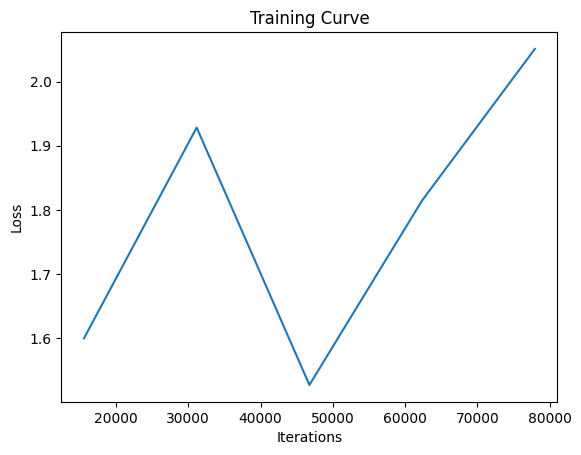

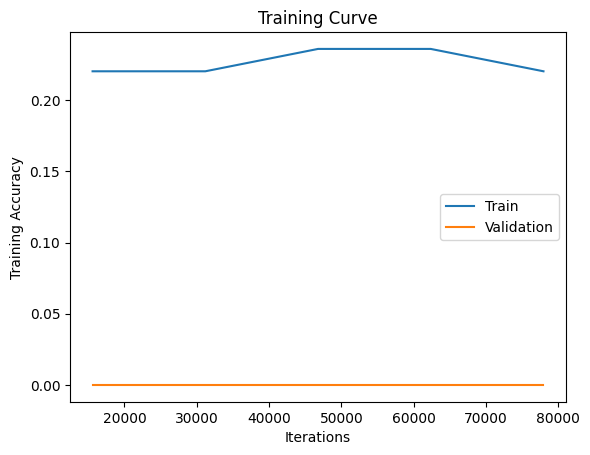

Final Training Accuracy: 0.22037595432090845
Final Validation Accuracy: 0.0
Total Training Time: 4465.29 seconds


In [11]:
model_1 = CNN()
batch_size = 1
learning_rate = 0.01
num_epochs = 5
use_cuda = True
train(model_1, train_data, val_data, batch_size, learning_rate, num_epochs)

Epoch: 1 | Training Accuracy: 0.29704240713415025 | Validation Accuracy: 0.316735112936345 | Training Loss: 0.027176305170982115 | Validation Loss: 0.18206213580237496
Epoch: 2 | Training Accuracy: 0.4071983062808751 | Validation Accuracy: 0.4224845995893224 | Training Loss: 0.025249567724043322 | Validation Loss: 0.15974990526835123
Epoch: 3 | Training Accuracy: 0.4444088022069673 | Validation Accuracy: 0.4589322381930185 | Training Loss: 0.022008111399988973 | Validation Loss: 0.13858004411061606
Epoch: 4 | Training Accuracy: 0.50683261692436 | Validation Accuracy: 0.5256673511293635 | Training Loss: 0.020038883532247236 | Validation Loss: 0.14567097028096518
Epoch: 5 | Training Accuracy: 0.5394238788734201 | Validation Accuracy: 0.5600616016427105 | Training Loss: 0.020243565882405928 | Validation Loss: 0.131642394595676


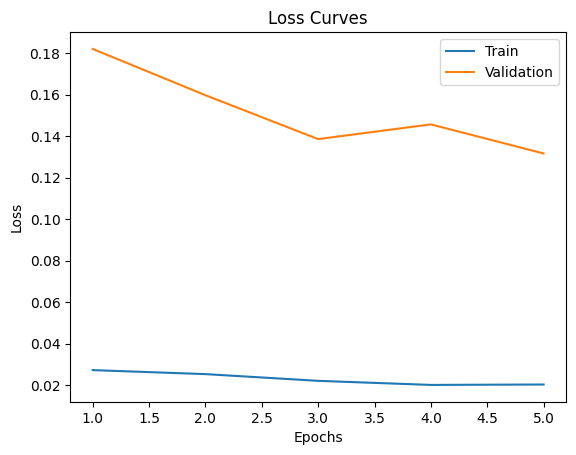

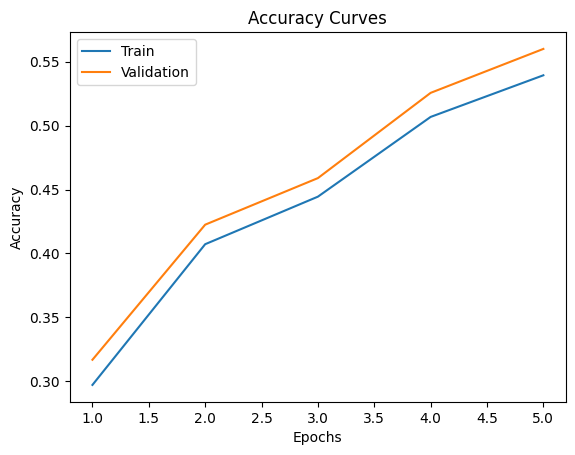

Final Training Accuracy: 0.5394238788734201
Final Validation Accuracy: 0.5600616016427105
Final Training Loss: 0.020243565882405928
Final Validation Loss: 0.131642394595676
Total Training Time: 3379.64 seconds


In [15]:
model_2 = CNN()
batch_size = 256
learning_rate = 0.002
num_epochs = 5
use_cuda = True
train2(model_2, train_data, val_data, batch_size, learning_rate, num_epochs)

# 2b. Try Transfer Learning with AlexNet

In [10]:
alexnet = torchvision.models.alexnet(pretrained=True)

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
if os.path.exists("torch-data-split") is False:
    os.mkdir("torch-data-split")

subfolders = ["train", "validation", "test"]

for item in subfolders:
  if os.path.exists("./torch-data-split/"+item) is False:
    os.makedirs(os.path.join("torch-data-split", item))

In [16]:
split = ['train', 'validation', 'test']

def save_as_torch(loader, num):
  n = 0
  for i, label in loader:
    features = alexnet.features(i)
    tensor = torch.from_numpy(features.detach().numpy())
    torch.save(tensor.squeeze(0),'./torch-data-split/' + split[num] + '/' + str(n) + '-' + str(label.item()) + '.tensor')
    n += 1

In [17]:
#obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# confirm output from AlexNet feature extraction
alexNet = torchvision.models.alexnet(pretrained=True)
features = alexNet.features(images)
features.shape

torch.Size([1, 256, 8, 8])

In [25]:
#call save_as_torch function for the the train, val, and test loader
save_as_torch(train_loader, 0)

In [32]:
save_as_torch(val_loader, 1)

In [33]:
save_as_torch(test_loader, 2)

In [ ]:
path_train = './torch-data-split/train'

for item in os.scandir(path_train):
    if item.is_file():
        print(item.path)

In [ ]:
new_train_path = './torch-data-split/train/'
train_data_net = torchvision.datasets.DatasetFolder(new_train_path, loader = torch.load, extensions=('.tensor'))

new_val_path = './torch-data-split/validation/'
val_data_net = torchvision.datasets.DatasetFolder(new_val_path, loader = torch.load, extensions=('.tensor'))

new_test_path = './torch-data-split/test/'
test_data_net = torchvision.datasets.DatasetFolder(new_test_path, loader = torch.load, extensions=('.tensor'))

In [22]:
class new_model(nn.Module):
    def __init__(self):
        super(new_model, self).__init__()
        input_size = 288
        num_classes = 6
        self.name = "new_model"
        self.alexnet = alexnet
        self.model = model_2
       #self.fc = nn.Linear(4096 + input_size, num_classes) # input_size is the size of the input to your trained model

        self.fc1 = nn.Linear(4096 + (10 * 29 * 29), 50)
        self.fc2 = nn.Linear(50, 6) # 6 classes

    def forward(self, x):
        x1 = self.alexnet(x)
        x2 = self.model(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

In [12]:
def alexNetTrain(model, train_data, val_data, batch_size=64, learning_rate=0.001, num_epochs=1):
  
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                              num_workers=0, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                              num_workers=0, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
 
    iters, losses, train_acc, val_acc = [], [], [], []

    n = 0 
    start_time = time.time()
    for epoch in range(num_epochs):
        for features, labels in iter(train_loader):
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            #############################################
            
            
            out = model(features)      # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n = n+1


        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy 
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
        
        print("Epoch:", epoch + 1, "| Training Accuracy:", train_acc[epoch], "| Validation Accuracy:", val_acc[epoch])

        # checkpoints
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        model_path = "saved-models/" + model_path
        torch.save(model.state_dict(), model_path)

    end_time = time.time()

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total Training Time:", round(end_time - start_time, 2), "seconds")

Epoch: 1 | Training Accuracy: 0.3931481362674023 | Validation Accuracy: 0.38295687885010266
Epoch: 2 | Training Accuracy: 0.4761660357990633 | Validation Accuracy: 0.4548254620123203
Epoch: 3 | Training Accuracy: 0.5168409572079297 | Validation Accuracy: 0.4748459958932238
Epoch: 4 | Training Accuracy: 0.5632899210880862 | Validation Accuracy: 0.4948665297741273
Epoch: 5 | Training Accuracy: 0.612882530313723 | Validation Accuracy: 0.5436344969199178
Epoch: 6 | Training Accuracy: 0.6363636363636364 | Validation Accuracy: 0.526694045174538
Epoch: 7 | Training Accuracy: 0.6590107140565856 | Validation Accuracy: 0.5415811088295688
Epoch: 8 | Training Accuracy: 0.6746006287290691 | Validation Accuracy: 0.545687885010267
Epoch: 9 | Training Accuracy: 0.7080900750625522 | Validation Accuracy: 0.5272073921971252
Epoch: 10 | Training Accuracy: 0.7339449541284404 | Validation Accuracy: 0.5436344969199178


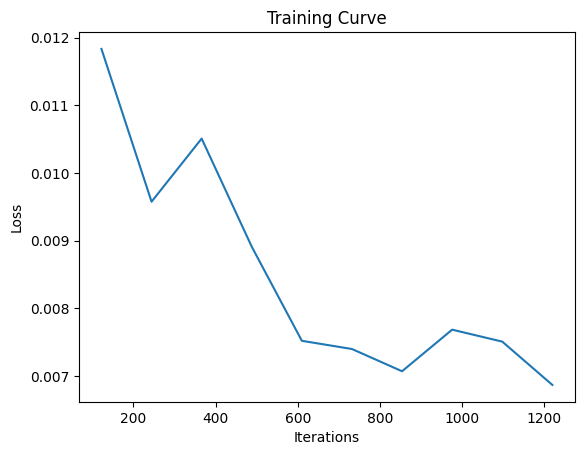

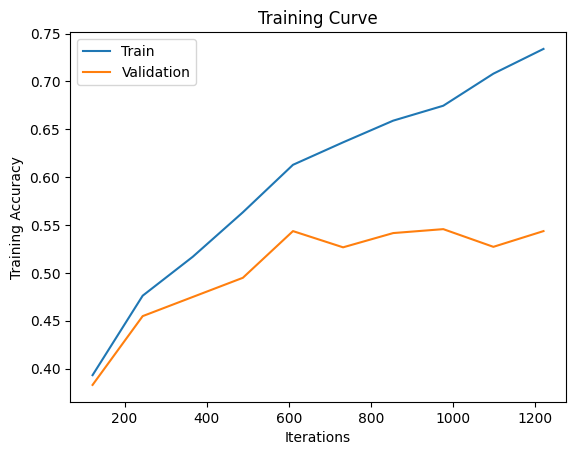

Final Training Accuracy: 0.7339449541284404
Final Validation Accuracy: 0.5436344969199178
Total Training Time: 6067.38 seconds


In [23]:
use_cuda = True
model_net = CNN()
alexNetTrain(model_net, train_data, val_data, batch_size=128, learning_rate=0.01, num_epochs=10)

Epoch: 1 | Training Accuracy: 0.20420863540129594 | Validation Accuracy: 0.20790554414784393
Epoch: 2 | Training Accuracy: 0.21793802527747483 | Validation Accuracy: 0.22125256673511293
Epoch: 3 | Training Accuracy: 0.29858215179316094 | Validation Accuracy: 0.2915811088295688
Epoch: 4 | Training Accuracy: 0.37730159748508374 | Validation Accuracy: 0.36344969199178645
Epoch: 5 | Training Accuracy: 0.4175915827291974 | Validation Accuracy: 0.4029774127310062
Epoch: 6 | Training Accuracy: 0.43671007891191377 | Validation Accuracy: 0.4358316221765914
Epoch: 7 | Training Accuracy: 0.4580740360556874 | Validation Accuracy: 0.45790554414784396
Epoch: 8 | Training Accuracy: 0.47700006415602747 | Validation Accuracy: 0.4625256673511294
Epoch: 9 | Training Accuracy: 0.477128376210945 | Validation Accuracy: 0.459958932238193
Epoch: 10 | Training Accuracy: 0.5154936806312953 | Validation Accuracy: 0.4989733059548255


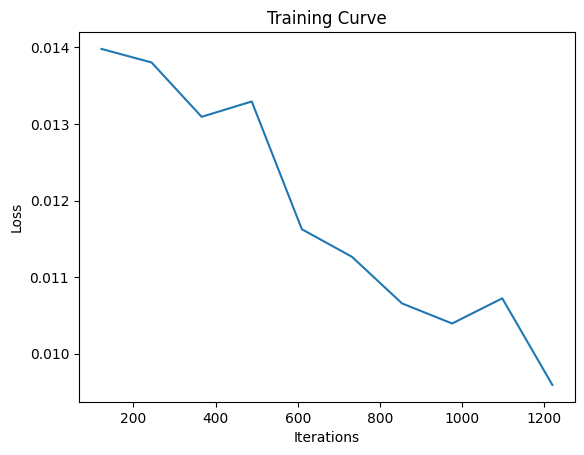

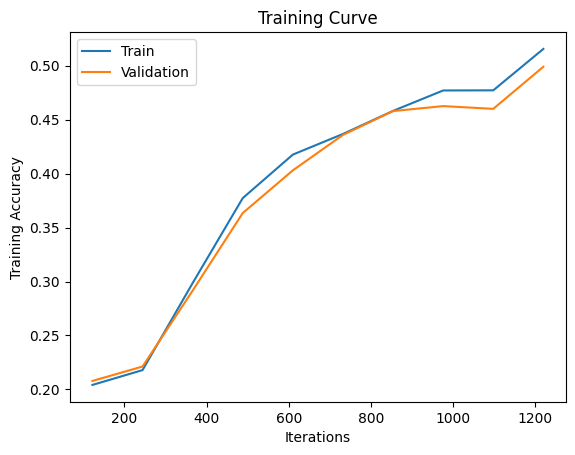

Final Training Accuracy: 0.5154936806312953
Final Validation Accuracy: 0.4989733059548255
Total Training Time: 5616.67 seconds


In [12]:
use_cuda = True
model_net = CNN()
alexNetTrain(model_net, train_data, val_data, batch_size=128, learning_rate=0.001, num_epochs=10)

In [1]:
use_cuda = True
model_net2 = new_model()
alexNetTrain(model_net2, train_data, val_data, batch_size=256, learning_rate=0.002, num_epochs=10)

NameError: name 'new_model' is not defined

# 3. Sanity Check: Overfit to a Small Dataset

In [140]:
# Take a small sample from the training set
n = len(train_data)
n_small = int(0.001 * n)
small_data = torch.utils.data.Subset(train_data, range(n_small))
_ = torch.utils.data.Subset(train_data, range(n_small, n))

In [138]:
print(len(small_data))

77


In [129]:
small_data[0][0].shape

torch.Size([3, 288, 288])

In [130]:
small_data[0][1]

1

Epoch: 1 | Training Accuracy: 0.0 | Validation Accuracy: 0.0
Epoch: 2 | Training Accuracy: 0.0 | Validation Accuracy: 0.0
Epoch: 3 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 4 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 5 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 6 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 7 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 8 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 9 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 10 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 11 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 12 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 13 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 14 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 15 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 16 | Training Accuracy: 1.0 | Validation Accuracy: 1.0
Epoch: 17 | Train

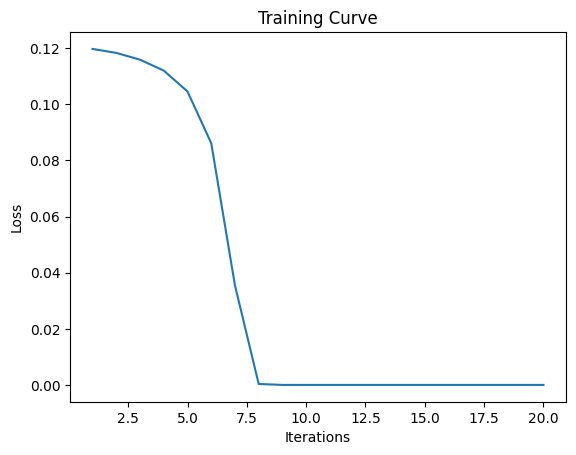

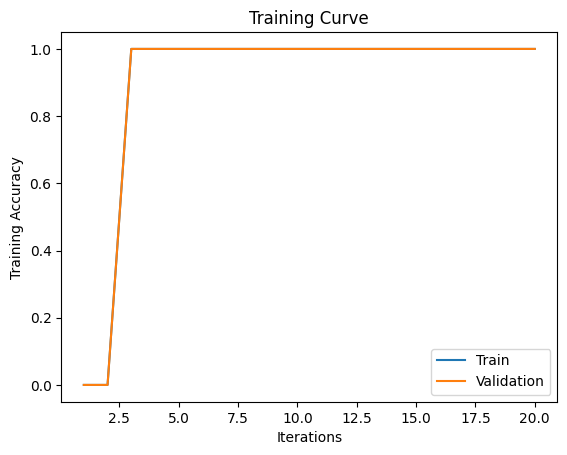

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0
Total Training Time: 19.32 seconds


In [141]:
model = CNN()
batch_size = len(small_data)
learning_rate = 0.01
num_epochs = 20
use_cuda = True
train(model, small_data, small_data, batch_size, learning_rate, num_epochs)

# 4. Hyperparameter Search

# 5. Test Data